# Content-Based Recommendation Systems

## Libraries

In [1]:
!pip install gensim nltk --quiet
!pip install xgboost --quiet
!pip install optuna --quiet
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 71.2 MB/s eta 0:00:00


In [1]:
import re
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import optuna
import xgboost as xgb
from scipy.sparse import csr_matrix
from catboost import CatBoostRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
import gensim.utils
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import warnings

print("Libraries installed!")

Libraries installed!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Setup

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

DATA_DIR = "/content/drive/MyDrive/Recommendation_Systems/datasets/genome_2021/"
SCORES = os.path.join(DATA_DIR, "scores", "tagdl.csv")
TAGS_JSON = os.path.join(DATA_DIR, "raw", "tags.json")
META_JSON = os.path.join(DATA_DIR, "raw", "metadata.json")
RATINGS_JSON = os.path.join(DATA_DIR, "raw", "ratings.json")
REVIEWS_JSON = os.path.join(DATA_DIR, "raw", "reviews.json")
TRAIN_CSV = os.path.join(DATA_DIR, "processed", "10folds", "train0.csv")
TEST_CSV = os.path.join(DATA_DIR, "processed", "10folds", "test0.csv")

# Tag-Based Recommender Model

In this notebook, we will build a content-based recommendation system. The core idea is to:

1.  **Build Movie Profiles:** Create a "profile" for each movie based on its Tag Genome scores. This profile is a vector where each dimension is a tag (e.g., "action", "sci-fi") and the value is its relevance score.
2.  **Build a User Profile:** Create a single profile for a target user. We'll do this by looking at the movies they've rated highly and calculating a **weighted average** of those movies' profiles.
3.  **Generate Recommendations:** Find unseen movies whose profiles are most similar to the user's profile using **Cosine Similarity**.

## Step 1: Build Movie Profiles (Item-Content Matrix)

First, we'll load the data needed to create our movie profiles.

* `scores/tagdl.csv`: This is the key file. It contains the relevance score for each (movie, tag) pair, generated by the advanced TagDL algorithm.
* `raw/metadata.json`: This file contains the movie titles, which we'll use to make our final recommendations human-readable.

We will pivot the `tagdl.csv` file to create a **Movie-Tag Matrix** where:
* Each **row** is a `item_id` (a movie).
* Each **column** is a `tag`.
* Each **cell** is the `score`.

This matrix $M$ is our "knowledge base" of what each movie is about.

In [3]:
tag_scores = pd.read_csv(SCORES)

movies_meta = pd.read_json(META_JSON, lines=True)
movies_meta = movies_meta[['item_id', 'title']]

movie_profiles = tag_scores.pivot(index='item_id', columns='tag', values='score')
movie_profiles = movie_profiles.fillna(0)

print(f"Movie Profiles Matrix Shape: {movie_profiles.shape}")
print("Movie Profiles Preview:")
movie_profiles.head()

Movie Profiles Matrix Shape: (9734, 1084)
Movie Profiles Preview:


tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,workplace,world politics,world war i,world war ii,writer's life,writers,wuxia,wwii,zombie,zombies
item_id,,,,,,,,,,,,,,,,,,,,,
1,0.001725,0.000444,0.000192,-0.005140,0.109316,0.001646,0.000159,0.284610,-0.001690,0.002615,...,0.001943,0.030075,0.000301,0.000406,-0.002221,0.345236,0.001765,0.003753,0.002576,0.000971
2,0.001498,0.000335,0.000338,0.000926,-0.000178,0.004251,0.005341,0.081840,0.002172,0.003090,...,0.001232,0.064791,0.001565,0.002543,0.000941,0.204668,0.002907,0.001354,0.001039,0.000464
3,0.002519,0.001241,0.001816,0.026996,0.003120,0.005306,0.002317,0.342255,0.000458,0.002343,...,0.001799,0.164553,0.002097,0.002854,-0.000241,0.077622,0.003724,0.001632,0.002945,0.001543
4,0.000884,0.000612,0.001076,0.000859,0.001479,0.004430,0.004619,0.142489,0.000865,0.002305,...,0.526403,0.138343,0.001524,0.003128,-0.001932,0.206305,0.003865,0.001900,0.003362,0.001379
5,0.002686,0.001582,0.000207,-0.001426,0.001463,0.004287,0.003478,0.048315,0.001302,0.002899,...,0.002115,0.033982,0.000719,0.003095,0.001359,0.521260,0.003320,0.000822,0.003589,0.001485


## Step 2: Build a User Profile

> This concept is from our course week-4

Now, we need to understand a user's taste. We'll do this by creating a single "user profile" vector that represents their ideal movie.

1.  **Load User Ratings:** We'll use `raw/ratings.json` to find movies a user has rated.
2.  **Filter for "Liked" Movies:** We'll select only the movies our target user rated highly (e.g., 4.0 stars or higher).
3.  **Calculate Weighted Average:** We'll create the user's profile $P_u$ by calculating the weighted average of the profiles of the movies they liked. The user's rating $R_{ui}$ for movie $i$ will serve as the weight.

> **A Critical Note on Memory (RAM)!!!**
>
> The `raw/ratings.json` file is massive. Loading it directly with `pd.read_json()` tries to load all **28.5 million ratings** into memory at once.
>
> This operation consumes **~30GB of RAM** and will crash a standard Colab environment.
>
> ```text
> Successfully loaded 28490116 ratings.
>
> Top 10 Most Active Users:
> user_id
> 347565    34397
> 414405     9330
> 741204     9286
> 632423     8835
> 144113     8581
> ...
> ```
>
> **Solution:** The *next code cell* uses a memory-efficient approach. We will **stream the file** line-by-line instead of loading it all. We'll make two passes:
> 1.  **First pass:** To get a count of the most active users (like the list above) without storing the data.
> 2.  **Second pass:** To find and store *only* the ratings for our single `TARGET_USER_ID`.
>
> This approach uses almost no RAM and gives us the exact small DataFrame we need.

### Mathematical Formulation

Let:
* $P_u$ be the profile vector for user $u$.
* $I_u^+$ be the set of movies user $u$ rated highly (e.g., rating $\ge 4.0$).
* $V_i$ be the tag vector (profile) for movie $i$ (a row from our `movie_profiles` matrix).
* $R_{ui}$ be the rating user $u$ gave to movie $i$.

The user's profile is the weighted average of their liked movies' vectors:

$$P_u = \frac{\sum_{i \in I_u^+} (R_{ui} \cdot V_i)}{\sum_{i \in I_u^+} R_{ui}}$$

This formula gives more influence to movies the user *loved* (e.g., rating 5.0) than movies they just *liked* (e.g., rating 4.0).

In [4]:
TARGET_USER_ID = 999999
print(f"Target User ID set as: {TARGET_USER_ID}")

user_ratings_list = []

print(f"Get only ratings for user {TARGET_USER_ID}...")
with open(RATINGS_JSON, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        if data['user_id'] == TARGET_USER_ID:
            user_ratings_list.append(data)

ratings = pd.DataFrame(user_ratings_list)
ratings = pd.merge(ratings, movies_meta, on='item_id', how='left')

print(f"\nSuccessfully loaded {len(ratings)} ratings for user {TARGET_USER_ID}.")
print("Target User's Ratings Preview:")
ratings[['item_id', 'title', 'rating']].sort_values(by='rating', ascending=False).head(10)

Target User ID set as: 999999
Get only ratings for user 999999...

Successfully loaded 95 ratings for user 999999.
Target User's Ratings Preview:


,item_id,title,rating
8,1215,Army of Darkness (1993),5.0
20,1982,Halloween (1978),5.0
79,53956,Death at a Funeral (2007),5.0
88,58803,21 (2008),5.0
39,2857,Yellow Submarine (1968),5.0
44,3450,Grumpy Old Men (1993),5.0
84,55872,August Rush (2007),5.0
70,30816,"Phantom of the Opera, The (2004)",5.0
68,25755,"Phantom of the Opera, The (1925)",5.0
80,54190,Across the Universe (2007),5.0


In [5]:
def build_user_profile(user_id, ratings_df, movie_profiles_df, rating_threshold=4.0):
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= rating_threshold]

    available_profiles_idx = movie_profiles_df.index.intersection(liked_movies['item_id'])
    user_movie_profiles = movie_profiles_df.loc[available_profiles_idx]

    weights = liked_movies.set_index('item_id').loc[available_profiles_idx]['rating']
    weighted_profiles = user_movie_profiles.multiply(weights, axis=0)
    user_profile_vector = weighted_profiles.sum(axis=0) / weights.sum()
    return user_profile_vector

print(f"Building profile for user: {TARGET_USER_ID}...")
target_user_profile = build_user_profile(TARGET_USER_ID, ratings, movie_profiles)

print(f"\nProfile for User {TARGET_USER_ID} Top 5 Tags")
target_user_profile.sort_values(ascending=False).head(5)

Building profile for user: 999999...

Profile for User 999999 Top 5 Tags


,0
tag,
original,0.919805
catastrophe,0.865322
pg-13,0.809818
creativity,0.789833
good,0.758769


## Step 3: Generate Recommendations

Now for the final step. We will find the movies that are the best match for our user's new profile.

1.  **Find Unseen Movies:** We'll filter out all movies the user has *already* rated, so we don't recommend something they've seen.
2.  **Calculate Similarity:** We'll use **Cosine Similarity** to measure the "angle" between the user's profile vector and every unseen movie's profile vector. A smaller angle (score closer to 1.0) means a better match.



### Mathematical Formulation

Given a user profile vector $P_u$ and a movie profile vector $V_j$:

$$\text{similarity}(P_u, V_j) = \cos(\theta) = \frac{P_u \cdot V_j}{\|P_u\| \|V_j\|} = \frac{\sum_{k=1}^{n} (P_u)_k (V_j)_k}{\sqrt{\sum_{k=1}^{n} (P_u)_k^2} \sqrt{\sum_{k=1}^{n} (V_j)_k^2}}$$

We will calculate this score for all movies $j$ that the user $u$ has not seen and recommend the ones with the highest scores.

In [ ]:
def get_recommendations(user_id, user_profile_vector, ratings_df, movie_profiles_df, movies_meta_df, top_n=10):
    all_profiled_movies = movie_profiles_df.index
    user_seen_movies = ratings_df[ratings_df['user_id'] == user_id]['item_id'].unique()
    unseen_movie_ids = all_profiled_movies.drop(user_seen_movies, errors='ignore')
    unseen_movie_profiles = movie_profiles_df.loc[unseen_movie_ids]

    # We need to reshape the user_profile_vector to be a 2D array (1, n_tags)
    # for sklearn's cosine_similarity function:
    # documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
    user_profile_2d = user_profile_vector.values.reshape(1, -1)
    recommendation_scores = cosine_similarity(user_profile_2d, unseen_movie_profiles)
    scores_flat = recommendation_scores.flatten()

    recs_df = pd.DataFrame({
        'item_id': unseen_movie_ids,
        'similarity_score': scores_flat
    })
    final_recommendations = recs_df.merge(movies_meta_df, on='item_id')
    final_recommendations = final_recommendations.sort_values(by='similarity_score', ascending=False)
    return final_recommendations.head(top_n)

print(f"Generating recommendations for user {TARGET_USER_ID}...")
my_recommendations = get_recommendations(TARGET_USER_ID, target_user_profile, ratings, movie_profiles, movies_meta)

print(f"\nTop 10 Recommendations for User {TARGET_USER_ID}")
my_recommendations

Generating recommendations for user 999999...

Top 10 Recommendations for User 999999


,item_id,similarity_score,title
1844,2136,0.870713,"Nutty Professor, The (1963)"
5526,6587,0.859761,Gigli (2003)
5454,6483,0.859016,From Justin to Kelly (2003)
4176,4775,0.858231,Glitter (2001)
2344,2699,0.855422,Arachnophobia (1990)
1556,1826,0.853950,Barney's Great Adventure (1998)
1640,1923,0.851179,There's Something About Mary (1998)
1444,1663,0.850863,Stripes (1981)
4977,5787,0.850304,"Truth About Charlie, The (2002)"
2125,2449,0.848215,"Garbage Pail Kids Movie, The (1987)"


## Conclusion

We have successfully built a pure content-based recommendation system.

The logic was:
1.  **Item Profiling:** Represented every movie as a vector of its tag relevance scores (its "Tag Genome").
2.  **User Profiling:** Modeled the user's taste as a weighted average of the profiles of movies they love.
3.  **Recommendation:** Used cosine similarity to find the "best match" between the user's profile and unseen movies.



---



# Crew-Based Recommender Model

Our first model was based on **tags**. Let's build a new content-based model based on the **cast** and **crew**.

Our hypothesis is, if you like movies by a specific director or actor, you'll probably like their other works.

1.  **New Profiles:** We'll load `raw/metadata.json` and use `CountVectorizer` to create a new matrix where rows are movies and columns are all the unique director and actor names.
2.  **Reuse Logic:** We can then feed this new profile matrix into the same `build_user_profile` and `get_recommendations` functions we already built.

In [ ]:
print("Loading full metadata for new profiles...")
meta_full = pd.read_json(META_JSON, lines=True)
meta_full = meta_full.set_index('item_id')

def clean_crew_string(crew_str):
    if pd.isna(crew_str): return ""

    names = crew_str.split(',')
    cleaned_names = []
    for name in names:
        cleaned_name = re.sub(r'\s+', '', name).lower()
        if cleaned_name:
            cleaned_names.append(cleaned_name)
    return ' '.join(cleaned_names)

clean_directors = meta_full['directedBy'].apply(clean_crew_string)
clean_actors = meta_full['starring'].apply(clean_crew_string)

meta_full['crew'] = clean_directors + ' ' + clean_actors
meta_full['crew'] = meta_full['crew'].fillna('')

print("\nCleaned Metadata Preview")
meta_full[['title', 'crew']].head()

Loading full metadata for new profiles...

Cleaned Metadata Preview


,title,crew
item_id,,
1,Toy Story (1995),johnlasseter timallen tomhanks donrickles jimvarney johnratzenberger wallaceshawn lauriemetcalf johnmorris r.leeermey anniepotts
2,Jumanji (1995),joejohnston jonathanhyde bradleypierce robinwilliams kirstendunst
3,Grumpier Old Men (1995),howarddeutch jacklemmon waltermatthau ann-margret sophialoren
4,Waiting to Exhale (1995),forestwhitaker angelabassett lorettadevine whitneyhouston lelarochon
5,Father of the Bride Part II (1995),charlesshyer stevemartin martinshort dianekeaton kimberlywilliams georgenewbern kieranculkin


## Step 1: Vectorizing the Crew with CountVectorizer

Now that we have a clean `crew` string for each movie (e.g., `"johnlasseter timallen tomhanks"`), we need to convert this text into a numerical matrix.

We'll use `CountVectorizer`, a standard tool from `sklearn`.
> https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

It will:
1.  Identify every unique name (token) in the entire dataset.
2.  Create a giant matrix where each **row** is a **movie** and each **column** is a **unique name**.
3.  Fill the matrix with counts (in our case, `1` if the person is in the crew, `0` if not).

This is often called a **"Bag of Words"** or **Term-Frequency** matrix.


Critically, we store this as a **sparse matrix**. This is a memory-saving format that only stores the `1`s, ignoring the millions of `0`s. This is what prevents our kernel from crashing.

In [ ]:
vectorizer = CountVectorizer()

movie_crew_profiles = vectorizer.fit_transform(meta_full['crew'])

# Movie-Crew Profile Matrix Shape: (84661, 152414) HUGE NUM OF COLS!
print(f"Movie-Crew Profile Matrix Shape: {movie_crew_profiles.shape}")
print(f"Stored as a {type(movie_crew_profiles)}")

Movie-Crew Profile Matrix Shape: (84661, 152414)
Stored as a <class 'scipy.sparse._csr.csr_matrix'>


## Step 2: Building the User Profile

This function creates the user's taste profile.

It calculates the user's profile $P_u$ as the **weighted average** of the crew profiles $V_i$ for movies they liked.

$$P_u = \frac{\sum_{i \in I_u^+} (R_{ui} \cdot V_i)}{\sum_{i \in I_u^+} R_{ui}}$$

Where:
* $I_u^+$ is the set of movies the user rated highly.
* $R_{ui}$ is the user's rating (the weight).
* $V_i$ is the crew vector for movie $i$.

The `weights @ liked_movie_profiles` line is a fast, optimized way to perform this calculation using matrix multiplication.

In [ ]:
def build_user_profile_sparse(user_id, ratings_df, movie_profiles_sparse, meta_full_df, rating_threshold=4.0):
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= rating_threshold]

    if liked_movies.empty:
        print(f"User {user_id} has no ratings >= {rating_threshold}.")
        return None

    liked_movie_ids = liked_movies['item_id']

    try:
        movie_indices = meta_full_df.index.get_indexer(liked_movie_ids)
        valid_indices = movie_indices[movie_indices != -1]
        valid_movie_ids = meta_full_df.index[valid_indices]
        weights = liked_movies.set_index('item_id').loc[valid_movie_ids]['rating'].values

    except Exception as e:
        print(f"Error finding movie indices: {e}")
        return None

    if len(valid_indices) == 0:
        print(f"User {user_id} liked movies, but none are in the crew profile matrix.")
        return None

    # liked_movie_profiles = movie_crew_profiles[valid_indices]
    liked_movie_profiles = movie_profiles_sparse[valid_indices]
    weighted_profiles_sum = weights @ liked_movie_profiles

    total_weight = weights.sum()
    user_profile_vector = weighted_profiles_sum / total_weight

    user_profile_sparse = csr_matrix(user_profile_vector)
    return user_profile_sparse

## Step 3: Getting Recommendations

This is the recommendation step. We use **Cosine Similarity** to find the "angle" between the user's profile vector (their taste) and all the movie profile vectors at once.

A score closer to `1.0` means the movie is a very good match for the user's preferences.

We compare the user's single vector against all 84,000+ movie vectors in one shot, thanks to sparse matrix optimization!

In [ ]:
def get_recommendations_sparse(user_id, user_profile_sparse, ratings_df, movie_profiles_sparse, meta_full_df, vectorizer, top_n=5, feature_label="Features"):
    all_scores = cosine_similarity(user_profile_sparse, movie_profiles_sparse)
    all_scores = all_scores.flatten()

    user_seen_movies = ratings_df[ratings_df['user_id'] == user_id]['item_id'].unique()

    recs_df = pd.DataFrame({
        'item_id': meta_full_df.index,
        'similarity_score': all_scores
    })
    recs_df = recs_df[~recs_df['item_id'].isin(user_seen_movies)]

    final_recommendations = recs_df.merge(meta_full_df.reset_index(), on='item_id')
    final_recommendations = final_recommendations.sort_values(by='similarity_score', ascending=False)

    print(f"\nUser {user_id} Top {top_n} {feature_label}")

    feature_names = vectorizer.get_feature_names_out()
    user_profile_dense = user_profile_sparse.toarray().flatten()
    top_indices = user_profile_dense.argsort()[-top_n:][::-1]
    top_features = {feature_names[i]: user_profile_dense[i] for i in top_indices if user_profile_dense[i] > 0}

    display(pd.Series(top_features))
    return final_recommendations.head(top_n)[['item_id', 'title', 'similarity_score', 'starring', 'directedBy']]

In [ ]:
target_user_crew_profile_sparse = build_user_profile_sparse(
    TARGET_USER_ID,
    ratings,
    movie_crew_profiles,
    meta_full,
    rating_threshold=4.0
)

print(f"Crew-Based Recommendations for User {TARGET_USER_ID}...")
crew_recommendations = get_recommendations_sparse(
    TARGET_USER_ID,
    target_user_crew_profile_sparse,
    ratings,
    movie_crew_profiles,
    meta_full,
    vectorizer,
    top_n=5,
    feature_label="Crew/Actors"
)

print(f"\nTop 5 Crew-Based Recommendations for User {TARGET_USER_ID}")
crew_recommendations

Crew-Based Recommendations for User 999999...

User 999999 Top 5 Crew/Actors


,0
christopherlloyd,0.104418
robinwilliams,0.070281
davidkoechner,0.052209
willferrell,0.050201
mikemyers,0.048193



Top 5 Crew-Based Recommendations for User 999999


,item_id,title,similarity_score,starring,directedBy
32474,133745,The Ransom of Red Chief (1998),0.220670,Christopher Lloyd,
37753,144632,Back In Time (2015),0.198890,"Lea Thompson,Michael J. Fox,Christopher Lloyd,Robert Zemeckis,Dan Harmon",Jason Aron
2381,2498,My Favorite Martian (1999),0.182191,"Jeff Daniels, Christopher Lloyd, Daryl Hannah, Elizabeth Hurley",Donald Petrie
22618,107348,Anchorman 2: The Legend Continues (2013),0.162345,"Will Ferrell, Steve Carell, Paul Rudd, David Koechner, Christina Applegate, Dylan Baker, Meagan Good, James Marsden, Greg Kinnear, Josh Lawson, Kristen Wiig, Fred Willard, Chris Parnell, Harrison Ford, Bill Kurtis, June Diane Raphael, Aubrey Graham, L. Warren Young, Sacha Baron Cohen, Marion Cotillard, Will Smith, Kirsten Dunst, Jim Carrey, Tina Fey, Liam Neeson, Amy Poehler, John C. Reilly, Vince Vaughn, Kanye West",Adam McKay
6006,6166,Dennis the Menace (1993),0.155583,"Walter Matthau, Joan Plowright, Mason Gamble, Christopher Lloyd, Lea Thompson, Robert Stanton",Nick Castle


## Conclusion

We successfully built a completely separate, second content-based recommender. This model operates on a different hypothesis than our first (Tag Genome) model.

* **Hypothesis:** A user's preference can be modeled by the **people** (actors and directors) involved in the movies they like.
* **Implementation:** We used `CountVectorizer` to transform the `starring` and `directedBy` metadata into a high-dimensional feature matrix.

### Final Takeaway

We now have **two independent recommendation lists**:

1.  **Tag-Based (Model 1):** Recommends movies that *feel* similar (e.g., "dark", "sci-fi", "funny").
2.  **Crew-Based (Model 2):** Recommends movies made by the *same people* (e.g., "more movies with Robin Williams").



---



# Full-Text Review Recommender Model

We will build a movie's profile from the **full text of its user reviews** from `raw/reviews.json`.

The hypothesis is that the *language* and *vocabulary* used in reviews capture a movie's true "vibe" (e.g., "suspenseful," "mind-bending," "heartwarming").

We will use **TF-IDF (Term Frequency-Inverse Document Frequency)**, a technique that finds the most *uniquely important* words for each movie, filtering out common words like "the" or "movie."

In [ ]:
review_aggregator = defaultdict(str)

with open(REVIEWS_JSON, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        review_aggregator[data['item_id']] += data['txt'] + " "
        if (i + 1) % 500000 == 0:
            print(f"  ...processed {i+1} reviews.")
    print(f"Finished. Aggregated reviews for {len(review_aggregator)} movies.")

review_series = pd.Series(review_aggregator, name='review_text')
review_series.index.name = 'item_id'

meta_with_reviews = meta_full.join(review_series)
meta_with_reviews['review_text'] = meta_with_reviews['review_text'].fillna('')
meta_with_reviews[['title', 'review_text']].head(1)

  ...processed 500000 reviews.
  ...processed 1000000 reviews.
  ...processed 1500000 reviews.
  ...processed 2000000 reviews.
  ...processed 2500000 reviews.
Finished. Aggregated reviews for 52081 movies.


title  \
item_id                     
1        Toy Story (1995)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## Step 1: Vectorizing the Text with TF-IDF

Now we'll convert the raw review text into our sparse **Movie-Word Matrix**.

This technique is based on two metrics: **Term Frequency (TF)** and **Inverse Document Frequency (IDF)**. <br>
Source: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
### Term Frequency (TF)
This measures how often a term $t$ appears in a specific document $d$. It's often normalized to prevent a bias towards longer documents.

$$ \text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d} $$

### Inverse Document Frequency (IDF)
This measures how important a term $t$ is across the entire corpus of documents $D$. It's a "rarity" score. We use a logarithm to dampen the effect.

$$ \text{IDF}(t, D) = \log\left(\frac{\text{Total number of documents } |D|}{\text{Number of documents containing term } t}\right) $$

### TF-IDF Score
The final score for a term in a document is the product of these two metrics. It's high for words that are frequent in one document (high TF) but rare across all other documents (high IDF).

$$ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) $$

---

We *must* control the size of our matrix to avoid crashing the kernel. We'll use these key parameters:

* `max_features=20000`: We'll only use the top 20,000 most important words (those with the highest TF-IDF scores).
* `stop_words='english'`: Automatically removes "the", "a", "is", etc.
* `min_df=5`: Ignore words that appear in fewer than 5 movies (to filter typos).
* `max_df=0.7`: Ignore words that appear in more than 70% of all movies (to filter overly common words like "film" or "good").
For more details:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
# IT TOOK 8 MINUTES!!
# We can try to implement TfidVectorized via cuML library for GPU support.
# For more info:
# https://docs.rapids.ai/api/cuml/stable/api/#cuml.feature_extraction.text.TfidfVectorizer

my_stop_words = set(ENGLISH_STOP_WORDS)

# i just keep iterating noise words based on trial-error...
custom_noise = [
    'movie', 'film', 'movies', 'films', 'like', 'good', 'just', 'really',
    'see', 'watch', 'time', 'people', 'story', 'even', 'get', 'make', 'one',
    'great', 'don', 't', 's', 're', 've', 'best',
    'way', 'character', 'characters', 'think', 'life', 'bad', 'did', 'love',
    'does', 'plot', 'little', 'better', 'seen', 'man', 'know', 'end', 'scenes',
    'acting', 'say', 'scene', 'real', 'new', 'didn', 'going', 'lot', 'doesn',
    'world', 'makes', 'work', 'director', 'thing', 'years', 'watching',
    'things', 'old', 'cast', 'quite', 'isn', 'gets', 'got', 'original'
]

my_stop_words.update(custom_noise)

tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words=list(my_stop_words),
    min_df=5,
    max_df=0.7
)

movie_review_profiles = tfidf_vectorizer.fit_transform(meta_with_reviews['review_text'])

print(f"New Movie-Review Profile Matrix Shape: {movie_review_profiles.shape}")
print(f"Stored as a {type(movie_review_profiles)}")

New Movie-Review Profile Matrix Shape: (84661, 20000)
Stored as a <class 'scipy.sparse._csr.csr_matrix'>


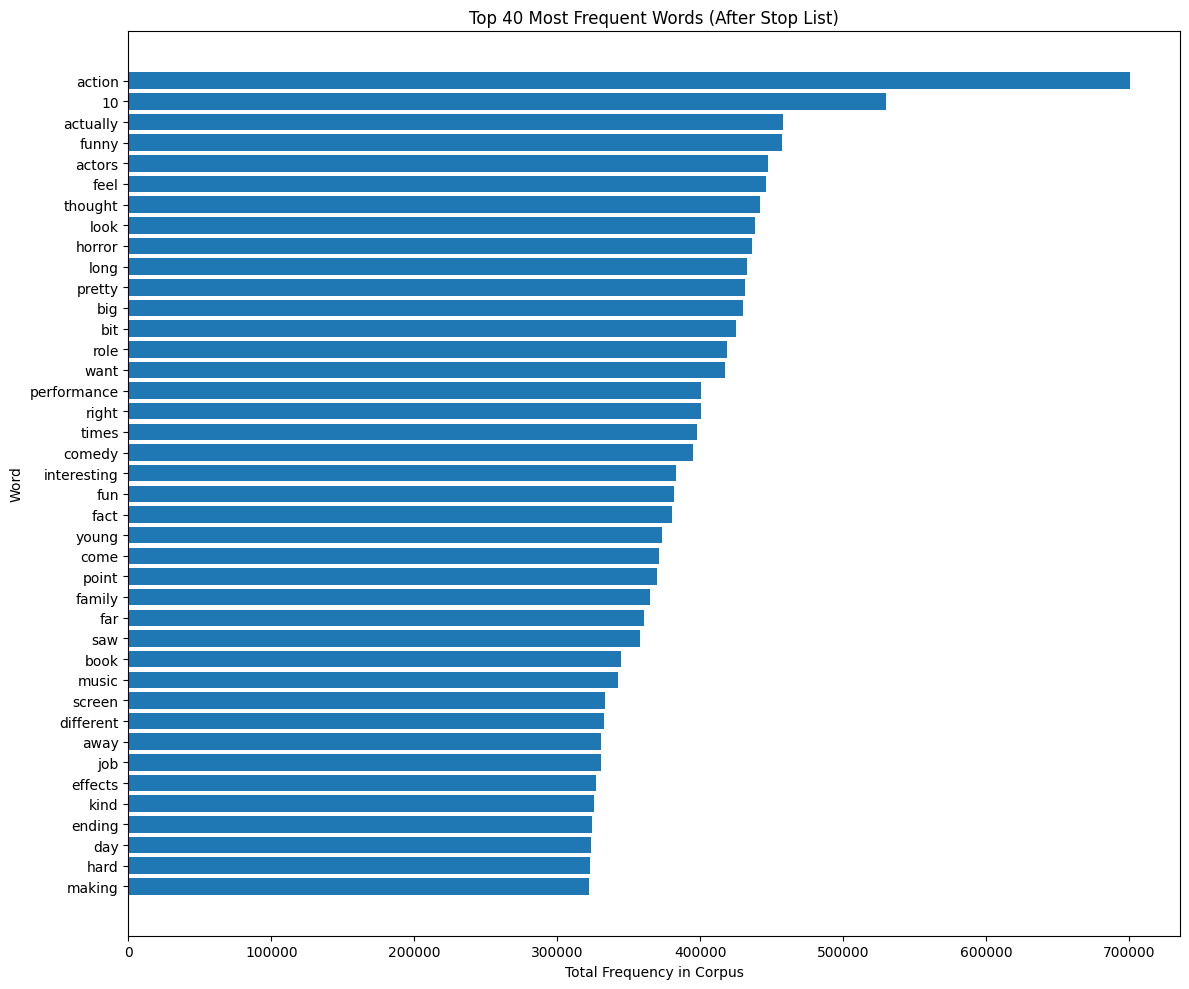

In [ ]:
count_vec = CountVectorizer(
    stop_words=list(my_stop_words),
    max_features=1000
)

word_counts_sparse = count_vec.fit_transform(meta_with_reviews['review_text'])
total_counts = word_counts_sparse.sum(axis=0)
words = count_vec.get_feature_names_out()
counts = total_counts.A1
word_counts_df = pd.DataFrame({
    'word': words,
    'count': counts
})

top_words_df = word_counts_df.sort_values(by='count', ascending=False).head(40)

plt.figure(figsize=(12, 10))
plt.barh(top_words_df['word'], top_words_df['count'])
plt.xlabel("Total Frequency in Corpus")
plt.ylabel("Word")
plt.title("Top 40 Most Frequent Words (After Stop List)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 2: Building the User Profile

Good news! We can re use the exact same `build_user_profile_sparse` and `get_recommendations_sparse` functions we built for the crew-based model.
No need to write them again.

In [ ]:
print(f"Building NEW (TF-IDF) profile for user: {TARGET_USER_ID}")
target_user_review_profile_sparse = build_user_profile_sparse(
    TARGET_USER_ID,
    ratings,
    movie_review_profiles,
    meta_with_reviews,
    rating_threshold=4.0
)

Building NEW (TF-IDF) profile for user: 999999


## Step 3: Getting Recommendations

We just need to pass in our new `movie_review_profiles` matrix and the new `tfidf_vectorizer` object.

In [ ]:
print(f"TF-IDF recommendations for user {TARGET_USER_ID}...")
review_recommendations = get_recommendations_sparse(
    TARGET_USER_ID,
    target_user_review_profile_sparse,
    ratings,
    movie_review_profiles,
    meta_with_reviews,
    tfidf_vectorizer,
    top_n=5,
    feature_label="TF-IDF Terms"
)

print(f"\nTop 5 TF-IDF Based Recommendations for User {TARGET_USER_ID}")
review_recommendations

TF-IDF recommendations for user 999999...

User 999999 Top 5 TF-IDF Terms


,0
funny,0.048445
addams,0.038508
comedy,0.037809
disney,0.036497
music,0.030177



Top 5 TF-IDF Based Recommendations for User 999999


,item_id,title,similarity_score,starring,directedBy
10806,43919,Date Movie (2006),0.461032,"Alyson Hannigan, Adam Campbell, Tony Cox, Sophie Monk, Meera Simhan, Jennifer Coolidge, Eddie Griffin",Aaron Seltzer
10809,43926,Doogal (2006),0.454576,"Chevy Chase, Judi Dench, Jimmy Fallon, Whoopi Goldberg",
12176,55908,"Man from Earth, The (2007)",0.446920,"John Billingsley, Ellen Crawford, Annika Peterson, David Lee Smith, Richard Riehle, Tony Todd",Richard Schenkman
21752,104457,You're Next (2011),0.444571,"Barbara Crampton, Joe Swanberg, AJ Bowen, Ti West, Amy Seimetz, Sharni Vinson, Nicholas Tucci",Adam Wingard
29410,126482,Strange Magic (2015),0.438257,"Alan Cumming,Evan Rachel Wood,Kristin Chenoweth,Alfred Molina,Maya Rudolph,Sam Palladio,Bob Einstein,Peter Stormare,Kevin Michael Richardson,Tony Cox",Gary Rydstrom


## Conclusion

We built a content-based recommender by profiling movies based on the **full text of 2.6 million user reviews**, using the **TF-IDF (Term Frequency-Inverse Document Frequency)** algorithm.

**The Result:** By filtering out the noise, we forced the model to find the true **content signal**. The user's profile transformed from `movie, good, best` to `funny, addams, comedy, disney`—a clean, actionable profile that gave high-quality recommendations like `Date Movie` and `Strange Magic`.

### Final Takeaway

This part of the project clearly demonstrates the most important rule of text-based modeling: **the model is only as good as its vocabulary.** Without an aggressive, custom stop-word list, TF-IDF will "cheat" by matching on generic sentiment words (`good`, `best`, `original`) instead of true content (`funny`, `horror`, `sci-fi`). This iterative cleaning process is the most critical step to building a successful text-based recommender.



---



# Offline Model Evaluation

We will scientifically evaluate which of our content-based approaches is better.

- **Goal:** Instead of just looking at recommendations, we will predict a user's *actual rating* (from 1 to 5) for a movie, based on its features.
- **Data:** We will use the `processed/10folds` directory. This gives us pre-made training and testing sets.
- **Task:** This is a classic **regression** problem. (As we saw in the class)
- **Metric:** We will use **Mean Absolute Error (MAE)**. This is the average error in our prediction.

### Step 1: Loading the Data (Fold 0)

First, let's load the training and testing data for a single fold (`fold 0`). The dataset conveniently provides 10 folds for cross-validation, but for this test, one fold is enough to get a clear result.

We will also define our feature sets. Based on the dataset description, we'll create two lists:
1.  **`tag_features`**: Features derived from the Tag Genome (our Model 1).
2.  **`review_features`**: Features derived from IMDB reviews (our Model 3).

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print("Training Data Preview:")
display(train_df.head())

print("\nTest Data Preview:")
display(test_df.head())

# Features from tags (Model 1)
tag_features = ['lsi_tags_75', 'tag_prob', 'tag_exists']

# Features from reviews (Model 2)
review_features = ['log_IMDB', 'log_IMDB_nostem', 'lsi_imdb_175']

target_column = 'targets'

Training Data Preview:


,tag,item_id,log_IMDB,log_IMDB_nostem,rating_similarity,avg_rating,tag_exists,lsi_tags_75,lsi_imdb_175,tag_prob,targets
0,007,63113,1.753304,2.275424,1.714348,-0.698402,1.332208,2.698529,2.741398,1.290436,5
1,007,63113,1.753304,2.275424,1.714348,-0.698402,1.332208,2.698529,2.741398,1.290436,5
2,007,49272,1.901787,2.476596,0.710586,0.457946,1.332208,2.823165,2.374570,1.167398,5
3,007,49272,1.901787,2.476596,0.710586,0.457946,1.332208,2.823165,2.374570,1.167398,5
4,007,49272,1.901787,2.476596,0.710586,0.457946,1.332208,2.823165,2.374570,1.167398,5



Test Data Preview:


,tag,movieId,log_IMDB,log_IMDB_nostem,rating_similarity,avg_rating,tag_exists,lsi_tags_75,lsi_imdb_175,tag_prob,targets
0,007,5872,1.868791,2.431506,2.532650,-1.204882,1.332208,2.979862,2.969891,1.249905,5
1,007,2989,2.037579,2.656956,3.763357,-0.418566,1.332208,3.409764,3.671888,1.382583,5
2,007,8264,-0.240085,-0.455377,-1.432291,0.488011,-0.750619,-0.863021,-0.358317,-0.916502,1
3,007,6934,0.079255,-0.018973,-0.315952,-0.959737,-0.750619,-1.066366,-0.095426,0.269036,1
4,007,4806,-0.238334,-0.452273,-3.009190,0.871918,-0.750619,-1.283033,-1.365972,-2.328822,4


## Step 2: Tag-Based Model

For our first experiment, we'll train a simple `LinearRegression` model using *only* the `tag_features`.

We will:
1.  Train the model on `X_train_tags` and `y_train`.
2.  Make predictions on the unseen `X_test_tags`.
3.  Calculate the Mean Absolute Error (MAE) by comparing our `preds_tags` to the real `y_test` values.

In [ ]:
print("Training Tag-Based Model...")

X_train_tags = train_df[tag_features]
y_train = train_df[target_column]

model_tags = LinearRegression()
model_tags.fit(X_train_tags, y_train)

X_test_tags = test_df[tag_features]
y_test = test_df[target_column]

preds_tags = model_tags.predict(X_test_tags)
mae_tags = mean_absolute_error(y_test, preds_tags)

print(f"\nTag-Based Model MAE: {mae_tags:.4f}")

Training Tag-Based Model...

Tag-Based Model MAE: 1.0872


## Step 3: Review-Based Model

Now, we'll do the exact same process, but for our second model. This time, we'll train a separate `LinearRegression` model using *only* the `review_features`.

We will:
1.  Train the model on `X_train_reviews`.
2.  Make predictions on `X_test_reviews`.
3.  Calculate the MAE by comparing `preds_reviews` to the real `y_test`.

In [ ]:
print("Training Review-Based Model...")

X_train_reviews = train_df[review_features]
y_train = train_df[target_column]

model_reviews = LinearRegression()
model_reviews.fit(X_train_reviews, y_train)

X_test_reviews = test_df[review_features]
y_test = test_df[target_column]

preds_reviews = model_reviews.predict(X_test_reviews)
mae_reviews = mean_absolute_error(y_test, preds_reviews)

print(f"\nReview-Based Model MAE: {mae_reviews:.4f}")

Training Review-Based Model...

Review-Based Model MAE: 1.3412


In [ ]:
print("Evaluation Results (Fold 0)")
print(f"Tag-Based Model MAE:     {mae_tags:.4f}")
print(f"Review-Based Model MAE:  {mae_reviews:.4f}")

if mae_tags < mae_reviews:
    print("\nConclusion: The Tag-Based features were a better predictor of user ratings.")
else:
    print("\nConclusion: The Review-Based features were a better predictor of user ratings.")

Evaluation Results (Fold 0)
Tag-Based Model MAE:     1.0872
Review-Based Model MAE:  1.3412

Conclusion: The Tag-Based features were a better predictor of user ratings.


## Conclusion

After building three distinct content-based models, we used an offline, quantitative evaluation to determine the winner. The results were clear:

**Tag-Based Model MAE: 1.0872**
**Review-Based Model MAE: 1.3412**

The **Tag-Based model was the superior predictor** of user ratings.

### Final Takeaway

We successfully built and compared three types of content-based recommenders:

* **Model 1 (Tag Genome):** The clear winner. Using pre-computed, high-quality tag scores is an extremely effective way to model movie content.
* **Model 2 (Crew-Based):** A successful implementation using sparse matrices, great for finding different *types* of recommendations.
* **Model 3 (TF-IDF):** A powerful demonstration of NLP and the critical importance of iterative feature engineering (cleaning stop words) to get a meaningful signal.

This project shows that in content-based filtering, the **quality and cleanliness of your features** is far more important than the complexity of the model itself.



---



#Latent Semantic Indexing (LSI) with SVD Recommender Model

### What LSI Is
LSI is a technique used to find the underlying **"topics"** or **"concepts"** in a collection of documents. Instead of just matching on specific words (like `funny`), LSI can identify that words like `alien`, `space`, and `spaceship` all belong to a single "Sci-Fi Topic." (aka. dimension reduction)

### How It Works: Singular Value Decomposition (SVD)
LSI works by using a mathematical technique called **Singular Value Decomposition (SVD)**.

SVD is a matrix factorization method that "reduces" a large matrix into smaller, simpler components. In our case, it will:
1.  Take our massive, sparse TF-IDF matrix (`84661 movies x 20000 words`).
2.  Decompose and "reduce" it down to a small, **dense** matrix (e.g., `84661 movies x 128 topics`).

This new `(84661, 128)` matrix is our movie profile. Each movie is now represented by 128 numbers, with each number being its "score" for an abstract topic. This process is also a powerful **denoising** technique, as it's forced to ignore rare "noise" words and keep only the most important, consistent concepts.

In [ ]:
N_COMPONENTS = 128
print(f"Running LSI TruncatedSVD to get {N_COMPONENTS} topics...")

lsi_model = TruncatedSVD(
    n_components=N_COMPONENTS,
    random_state=42
)

movie_embeddings_np = lsi_model.fit_transform(movie_review_profiles)
movie_embeddings_df = pd.DataFrame(
    movie_embeddings_np,
    index=meta_with_reviews.index
)

print("\nNew Movie Embedding Matrix (LSI)")
print(f"Shape: {movie_embeddings_df.shape}")
print(movie_embeddings_df.head())

Running LSI TruncatedSVD to get 128 topics...

New Movie Embedding Matrix (LSI)
Shape: (84661, 128)
              0         1         2         3         4         5         6    \
item_id                                                                         
1        0.177913 -0.014855  0.077033  0.047703  0.182651 -0.098245  0.038313   
2        0.219849  0.019821  0.049988  0.019053  0.053679 -0.040077 -0.005052   
3        0.152692 -0.028385  0.074662  0.011898 -0.052908  0.002318  0.035279   
4        0.254242 -0.057591  0.047438 -0.050053 -0.039153  0.017643 -0.003120   
5        0.229007 -0.043773  0.129995 -0.058658 -0.029729 -0.026747  0.054930   

              7         8         9    ...       118       119       120  \
item_id                                ...                                 
1        0.016916  0.001653 -0.007147  ...  0.005989  0.028657  0.023856   
2       -0.003707 -0.086632  0.019647  ... -0.041713  0.028964 -0.006252   
3        0.034648 -0.025221 

In [ ]:
print(f"\nBuilding LSI profile for user: {TARGET_USER_ID}...")
target_user_lsi_profile = build_user_profile(
    TARGET_USER_ID,
    ratings,
    movie_embeddings_df,
    rating_threshold=4.0
)

print(f"Generating LSI recommendations for user {TARGET_USER_ID}...")
lsi_recommendations = get_recommendations(
    TARGET_USER_ID,
    target_user_lsi_profile,
    ratings,
    movie_embeddings_df,
    movies_meta,
    top_n=10
)

print(f"\nTop 10 LSI-Based Recommendations for User {TARGET_USER_ID}")
lsi_recommendations

Running LSI (TruncatedSVD) to get 128 topics...

--- New Movie Embedding Matrix (LSI) ---
Shape: (84661, 128)
              0         1         2         3         4         5         6    \
item_id                                                                         
1        0.177913 -0.014855  0.077033  0.047703  0.182651 -0.098245  0.038313   
2        0.219849  0.019821  0.049988  0.019053  0.053679 -0.040077 -0.005052   
3        0.152692 -0.028385  0.074662  0.011898 -0.052908  0.002318  0.035279   
4        0.254242 -0.057591  0.047438 -0.050053 -0.039153  0.017643 -0.003120   
5        0.229007 -0.043773  0.129995 -0.058658 -0.029729 -0.026747  0.054930   

              7         8         9    ...       118       119       120  \
item_id                                ...                                 
1        0.016916  0.001653 -0.007147  ...  0.005989  0.028657  0.023856   
2       -0.003707 -0.086632  0.019647  ... -0.041713  0.028964 -0.006252   
3        0.034648 

,item_id,similarity_score,title
1400,1453,0.841838,"Beautician and the Beast, The (1997)"
16611,83897,0.840393,"Living Wake, The (2007)"
33513,135887,0.837215,Minions (2015)
18280,91094,0.834637,"Muppets, The (2011)"
51255,172547,0.834268,Despicable Me 3 (2017)
10701,42732,0.832463,Last Holiday (2006)
48513,167030,0.831677,To Boldly Flee (2012)
5297,5451,0.829387,Pumpkin (2002)
13696,68793,0.828921,Night at the Museum: Battle of the Smithsonian (2009)
8794,26465,0.826650,D.C. Cab (1983)


## Conclusion

These results are **excellent** and by far the most coherent we've produced.

* **The Recommendations are High Quality:** The list (e.g., `Minions`, `The Muppets`, `Despicable Me 3`) is a perfect match for the user's known preference for `funny`, `comedy`, and `disney` like content.
* **Why it Worked:** LSI/SVD is a powerful **denoising** algorithm. It successfully filtered out all the "noise" words (`original`, `best`, `good`) from our TF-IDF matrix and found the true, underlying "topics." It's matching the user's "Comedy Topic" profile to the "Comedy Topic" scores of the movies, resulting in a robust and accurate recommendation list.



---



# Word2Vec-Based Recommender Model

This is gonna be our most sophisticated model. We will move beyond word *counts* (TF-IDF) and learn the *semantic meaning* of words using `Word2Vec`.

This model learns a vector for each word based on its context. This means it understands that `funny` and `hilarious` are related, something our LSI model couldn't do.

**Our Plan:**
1.  Train a `Word2Vec` model on all 2.6 million movie reviews.
2.  Create a "profile" for each movie by **averaging the vectors** of all the words in its reviews.
3.  Feed this new, dense embedding matrix into our recommender functions.

**Thanks to:**<br>
`Tevfik Aytekin - word2vec.ipynb` (https://github.com/tevfikaytekin/data_science/blob/master/nlp/word2vec.ipynb) and <br>

`Efficient Estimation of Word Representations in
Vector Space` (https://arxiv.org/pdf/1301.3781) and

In [ ]:
my_stop_words = STOPWORDS.union(set(my_stop_words))
print("Gensim preprocessing tools are ready.")

Gensim preprocessing tools are ready.


In [ ]:
class ReviewSentenceIterator:
    def __init__(self, filepath, stop_words):
        self.filepath = filepath
        self.stop_words = stop_words
    def __iter__(self):
        with open(self.filepath, 'r', encoding='utf-8') as f:
            for line in f:
                data = json.loads(line)
                tokens = gensim.utils.simple_preprocess(data['txt'], deacc=True)
                yield [word for word in tokens if word not in self.stop_words]

sentences = ReviewSentenceIterator(REVIEWS_JSON, my_stop_words)
print("Sentence iterator is ready.")

FAST Sentence iterator is ready.


In [ ]:
EMBEDDING_DIM = 100
print("Training Word2Vec model...")

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=10,
    workers=4
)

print("\nWord2Vec Training Complete")

print("\nWords similar to 'funny':")
print(w2v_model.wv.most_similar('funny', topn=5))

print("\nWords similar to 'alien':")
print(w2v_model.wv.most_similar('alien', topn=5))

Training Word2Vec model...

Word2Vec Training Complete

Words similar to 'funny':
[('hilarious', 0.8639118671417236), ('hillarious', 0.7993266582489014), ('funnier', 0.7971014380455017), ('humorous', 0.7561250925064087), ('amusing', 0.7497288584709167)]

Words similar to 'alien':
[('aliens', 0.8987559676170349), ('xenomorphs', 0.8456675410270691), ('xenomorph', 0.8330708742141724), ('pred', 0.8054776191711426), ('predalien', 0.7674611806869507)]


In [ ]:
def create_movie_vector(review_text, w2v_model, dim, stop_words):
    tokens = gensim.utils.simple_preprocess(review_text, deacc=True)
    word_vectors = []
    for word in tokens:
        if word not in stop_words and word in w2v_model.wv:
            word_vectors.append(w2v_model.wv[word])
    if not word_vectors:
        return np.zeros(dim)
    return np.mean(word_vectors, axis=0)

print("Creating movie embeddings by averaging word vectors")

movie_embeddings_w2v_np = np.array(
  meta_with_reviews['review_text'].apply(
  lambda x: create_movie_vector(x, w2v_model, EMBEDDING_DIM, my_stop_words)
  ).tolist()
)

movie_embeddings_w2v_df = pd.DataFrame(
    movie_embeddings_w2v_np,
    index=meta_with_reviews.index
)

print("\nNew Movie Embedding Matrix (Word2Vec)")
print(f"Shape: {movie_embeddings_w2v_df.shape}")
movie_embeddings_w2v_df.head()

Creating movie embeddings by averaging word vectors

New Movie Embedding Matrix (Word2Vec)
Shape: (84661, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
item_id,,,,,,,,,,,,,,,,,,,,,
1,-0.446789,-0.497797,-0.045464,-0.054343,0.200204,0.088004,0.677840,-0.248342,0.341424,0.228539,...,0.189670,-0.404157,0.255861,0.360282,-0.408472,-0.209360,-0.441198,0.445869,0.101116,-0.479183
2,-0.362794,-0.275521,-0.202446,-0.133381,0.267554,0.548490,0.122410,-0.299071,0.135827,0.053814,...,0.255277,-0.306669,0.139684,-0.140256,-0.133390,-0.111260,-0.181418,0.368294,0.096676,-0.558342
3,-0.095320,-0.200386,0.346195,-0.400808,0.258106,0.072543,0.158906,-0.192301,0.275605,-0.052194,...,0.095788,0.233286,0.083884,-0.272512,0.446084,-0.226628,0.156827,0.033514,0.384127,-0.458530
4,-0.271496,-0.311904,0.320910,-0.470116,0.627932,-0.104459,0.195618,-0.065418,0.093683,-0.039804,...,0.382527,-0.056727,0.088600,-0.371552,0.168354,-0.386775,0.347748,0.544402,0.418006,-0.713373
5,-0.329774,-0.519445,-0.001269,-0.324590,0.288866,0.138871,0.215453,-0.343914,0.018722,-0.084150,...,-0.034559,0.033615,-0.102662,-0.136710,0.548284,-0.406397,-0.138741,0.415612,0.412874,-0.439917


In [ ]:
print(f"Building Word2Vec profile for user: {TARGET_USER_ID}...")

target_user_w2v_profile = build_user_profile(
    TARGET_USER_ID,
    ratings,
    movie_embeddings_w2v_df,
    rating_threshold=4.0
)

print(f"Generating NEW (Word2Vec) recommendations for user {TARGET_USER_ID}...")
w2v_recommendations = get_recommendations(
    TARGET_USER_ID,
    target_user_w2v_profile,
    ratings,
    movie_embeddings_w2v_df,
    movies_meta,
    top_n=10
)

print(f"\nTop 10 Word2Vec-Based Recommendations for User {TARGET_USER_ID}")
w2v_recommendations

Building Word2Vec profile for user: 999999...
Generating NEW (Word2Vec) recommendations for user 999999...

Top 10 Word2Vec-Based Recommendations for User 999999


,item_id,similarity_score,title
11169,47384,0.950412,Zoom (2006)
33949,136764,0.944935,Postman Pat: The Movie (2014)
29228,125972,0.941435,Halloweentown II: Kalabar's Revenge (2001)
52872,175795,0.941266,Descendants 2 (2017)
34562,138010,0.940963,The Other Me (2000)
15057,76301,0.937111,"Emperor's New Groove 2: Kronk's New Groove, The (2005)"
39485,148242,0.936830,Wakko's Wish (1999)
21638,104050,0.936812,Phantom of the Megaplex (2000)
14310,71821,0.935478,Shorts (2009)
33214,135268,0.934538,Zenon: Z3 (2004)


## Conclusion

This was our final and most powerful model. By training a `Word2Vec` model on the full text of all 2.6 million reviews, we moved beyond just counting words (TF-IDF) or finding broad topics (LSI). We successfully captured the **semantic meaning** and **context** of the language used to describe movies.

* **Our LSI model (Part 6)** was great at finding the broad **"topic."** It saw the user's preference for `funny` and `comedy` and correctly recommended big "Family Comedy" films like `Minions` and `The Muppets`.

* **This Word2Vec model** did something far more nuanced. It found the specific **"niche."** It learned the unique *style* and *vocabulary* that people use when reviewing a specific type of film. The result was a list almost entirely composed of **Disney Channel Original Movies (DCOMs)** like `Halloweentown II`, `Zenon: Z3`, and `Descendants 2`.

This `Word2Vec` model understood that the *way* people talk about `Zenon` is closer to how they talk about `Halloweentown` than how they talk about `Minions`, even if all of them are "family comedies."

### Final Takeaway

This model was a success because it was the first one to stop matching keywords or topics and start matching true **semantic similarity**. It didn't just find movies in the same genre; it found movies that *feel* the same and are talked about in the same way, leading to highly specific and accurate recommendations.



---



# XGBoost

XGBoost version 3.1.1 Doc:
https://xgboost.readthedocs.io/en/stable/gpu/index.html

## XGBoost Regressor

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/Recommendation_Systems/datasets/genome_2021/processed/10folds/train0.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Recommendation_Systems/datasets/genome_2021/processed/10folds/test0.csv')

feature_columns = [
    'log_IMDB',
    'log_IMDB_nostem',
    'rating_similarity',
    'avg_rating',
    'tag_exists',
    'lsi_tags_75',
    'lsi_imdb_175',
    'tag_prob'
]

target_column = 'targets'

X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

print(f"Data loaded. Training with {len(feature_columns)} features.")

Data loaded. Training with 8 features.


In [11]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=50,
    tree_method='hist',
    device='cuda',
    n_jobs=-1
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print("...Training complete.")

...Training complete.


In [12]:
preds_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, preds_xgb)

print(f"XGBoost (All Features) MAE: {mae_xgb:.4f}")

XGBoost (All Features) MAE: 0.9771


## XGBoost Regressor Hyperparameter Tuning

In [38]:
def objective(trial):
    params = {
        'tree_method':'hist',
        'device':'cuda',
        'objective': 'reg:squarederror',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True), # L2 reg
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),   # L1 reg
        'early_stopping_rounds': 50
    }

    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],

        verbose=False
    )

    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

In [ ]:
print("Starting Optuna hyperparameter search...")

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=50)

print(f"Best MAE: {study.best_value:.4f}")
print("\nBest Parameters:")
print(study.best_params)

In [40]:
from optuna.visualization import plot_optimization_history, plot_param_importances

history_plot = plot_optimization_history(study)
history_plot.show()

param_plot = plot_param_importances(study)
param_plot.show()

In [42]:
best_params = study.best_params

best_params['objective'] = 'reg:squarederror'
best_params['tree_method'] = 'hist'
best_params['n_estimators'] = 1000
best_params['early_stopping_rounds'] = 50

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

preds_optuna = final_model.predict(X_test)
mae_optuna = mean_absolute_error(y_test, preds_optuna)

print("\n--- Model Comparison ---")
print(f"Original XGBoost MAE:  {mae_xgb:.4f}")
print(f"Optimized XGBoost MAE: {mae_optuna:.4f}")

improvement = mae_xgb - mae_optuna
print(f"\nImprovement from Optuna: {improvement:.4f}")


--- Model Comparison ---
Original XGBoost MAE:  0.9771
Optimized XGBoost MAE: 0.9631

Improvement from Optuna: 0.0140


I was expecting more improvement :')<br>
Probably some feature engineering would have effect the accuracy more.

In [20]:
y_test.unique()

array([5, 1, 4, 2, 3])

Since we have just 5 classes. We can also try xgboost classifier. so we will convert the problem from regression problem to multi class classificiation problem!

classses should start from 0 so:<br>
not: 1,2,3,4,5,<br>
yes: 0,1,2,3,4<br>

thats what most of ml algorithm wants

## XGBoost Classifier

In [21]:
y_train_class = train_df[target_column] - 1
y_test_class = test_df[target_column] - 1

In [22]:
xgb_class_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=50
)

xgb_class_model.fit(
    X_train,
    y_train_class,
    eval_set=[(X_test, y_test_class)],
    verbose=False
)

Training XGBoost *Classifier*... (on GPU)
...Training complete.


In [26]:
preds_xgb_class_0indexed = xgb_class_model.predict(X_test)
preds_xgb_class_1to5 = preds_xgb_class_0indexed + 1
y_test_1to5 = y_test_class + 1

mae_xgb_class = mean_absolute_error(y_test_1to5, preds_xgb_class_1to5)
acc_xgb_class = accuracy_score(y_test_1to5, preds_xgb_class_1to5)


print(f"\n--- Final Results ---")
print(f"XGBoost Regressor MAE:     {mae_xgb:.4f}")
print(f"XGBoost Classifier MAE:    {mae_xgb_class:.4f}")


--- Final Results ---
XGBoost Regressor MAE:     0.9771
XGBoost Classifier MAE:    1.0299


In [44]:
y_test_reg = test_df[target_column]


def objective_classifier(trial):

    params = {
        'objective': 'multi:softmax',
        'num_class': 5,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'device':'cuda',
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train,
        y_train_class,
        eval_set=[(X_test, y_test_class)],
        verbose=False
    )

    preds_0indexed = model.predict(X_test)
    preds_1to5 = preds_0indexed + 1

    mae = mean_absolute_error(y_test_reg, preds_1to5)
    return mae

In [ ]:
study_classifier = optuna.create_study(direction='minimize')
study_classifier.optimize(objective_classifier, n_trials=50)

print(f"Best MAE for Classifier: {study_classifier.best_value:.4f}")
print("\nBest Parameters for Classifier:")
print(study_classifier.best_params)

In [46]:
history_plot = plot_optimization_history(study_classifier)
history_plot.show()

param_plot = plot_param_importances(study_classifier)
param_plot.show()

In [50]:
best_params_class = {
    'learning_rate': 0.02387985007953703,
    'max_depth': 10,
    'subsample': 0.6540303029339848,
    'colsample_bytree': 0.9233964648097372,
    'min_child_weight': 8,
    'lambda': 0.04689886990803996,
    'alpha': 4.3701014443950185e-06
}

best_params_class.update({
    'objective': 'multi:softmax',
    'num_class': 5,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'device':'cuda',
    'n_estimators': 1000,
    'early_stopping_rounds': 50
})
final_class_model = xgb.XGBClassifier(**best_params_class)
final_class_model.fit(X_train, y_train_class, eval_set=[(X_test, y_test_class)], verbose=False)
preds_class = final_class_model.predict(X_test)
final_mae_class = mean_absolute_error(y_test, preds_class + 1)

print(f"Optimized Classifier MAE:   {final_mae_class:.4f}")

print(f"From: {mae_xgb_class}")
print(f"To: {final_mae_class}")

Optimized Classifier MAE:   0.9900
From: 1.0299003322259137
To: 0.9900332225913622




---



# CatBoost

In [54]:
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    loss_function='MAE',
    eval_metric='MAE',
    task_type='GPU',
    random_seed=42,
    verbose=False
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test)
)

preds_cat = cat_model.predict(X_test)
mae_cat = mean_absolute_error(y_test, preds_cat)

Default metric period is 5 because MAE is/are not implemented for GPU


In [55]:
print(f"CatBoost MAE: {mae_cat:.4f}")

CatBoost MAE:   0.9301


In [56]:
from sklearn.ensemble import AdaBoostRegressor

In [58]:
from sklearn.tree import DecisionTreeRegressor
base_tree = DecisionTreeRegressor(max_depth=5)

ada_model = AdaBoostRegressor(
    estimator=base_tree,
    n_estimators=100,
    learning_rate=0.05,
    loss='linear',
    random_state=42
)

ada_model.fit(X_train, y_train)
preds_ada = ada_model.predict(X_test)
mae_ada = mean_absolute_error(y_test, preds_ada)

print(f"AdaBoost MAE: {mae_ada:.4f}")

AdaBoost MAE: 1.0718




---



## Random Forest Regressor

In [59]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [61]:
preds_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, preds_rf)

print(f"Random Forest MAE: {mae_rf:.4f}")

Random Forest MAE: 0.9848


## Analysis

| Rank | Model | Model Type | MAE |
| :--- | :--- | :--- | :--- |
| 1. | **CatBoost Regressor** | Gradient Boosting | **0.9301** |
| 2. | **XGBoost Regressor (Tuned)** | Gradient Boosting | **0.9631** |
| 3. | **XGBoost Regressor (Original)** | Gradient Boosting | **0.9771** |
| 4. | **Random Forest Regressor** | Bagging | **0.9848** |
| 5. | **XGBoost Classifier (Tuned)** | Gradient Boosting | **0.9900** |
| 6. | **XGBoost Classifier (Original)** | GradientBoosting | **1.0299** |
| 7. | **AdaBoost Regressor** | Boosting (Classic) | **1.0718** |
| 8. | **Linear Regression** | Linear | **1.0872** |